<a href="https://colab.research.google.com/github/StillWork/AIDD-2208-add/blob/main/c_84_2_ML_Intro_Solubility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepChem을 이용한 머신러닝 이해

## 머신러닝 모델 작성 단계

1. 데이터 선택
2. 모델 선택
3. 모델 훈련 (파라미터 학습)
4. 검증 데이터로 모델 성능 평가
5. 모델 사용 (회귀, 분류, 생성)


## 문제: 용해도 예측
- 물질이 용매에 포화상태까지 녹을 수 있는 한도 ( - log(solubility) measured in moles/liter)
- 머신러닝의 동작 이해 (X로부터 y를 예측하는 모델 이해)
- chemical formula(X)로부터 용해도(y)를 예측
- 알려진 실제 화합물의 용해도로부터,유사한 화합물의 용해도를 예측하는 데 사용
- DeepChem 라이브러리 사용법
 - MoleculeNet 사용

##  데이터
- 데이터를 MoleculeNet에서 가져오며 Delaney solubility data set을 사용
 - 존 델라니가 2004년에 발표한 논문 데이터
 - log(solubility) measured in moles/liter
- load_delaney() 함수로 데이터를 다운받는다
 - 아래에서는 특성(feature, 표현법)으로 그래프 구조 정보를 사용한다고 선택했다
 - 다운받은 데이터를 세가지 정보를 제공한다 (작업, 데이터, 변환)
 - 데이터는 다시 세가지로 구성되어 있다

## 모델
- 랜덤 포레스트
 - CircularFingerprint 사용
- 그래프 컨볼류션 네트워크
 - featurizer='GraphConv' 사용
 - 분자의 SMILES를 그래프 합성곱 모델용으로 선택

# Import

In [1]:
# !pip install deepchem
import deepchem as dc

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit import DataStructs

import tempfile
from itertools import islice
from IPython.display import Image, display
from deepchem.utils.data_utils import load_from_disk  

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# 데이터

- SMILES, 용해도 등 분자특성을 포함한 csv 파일을 다운로드
 - wget 또는 curl 사용
- 여기서는 `smiles` 와 `Measured log-solubility in mols/liter` 컬럼만 사용한다

In [ ]:
!wget https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv

## 데이터프레임으로 읽기
- load_from_disk()는 판다스의 read_csv()와 같은 역할을 수행하는 함수 (데이터프레임으로 읽는다)


In [3]:
from deepchem.utils.data_utils import load_from_disk  

dataset = load_from_disk("delaney-processed.csv")
print(dataset.shape)
dataset[:3]

(1128, 10)


,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)


## 데이터 탐색 (EDA)

In [4]:
# 이미지 파일들을 출력하는 함수 정의
def display_images(filenames):
    for file in filenames:
      display(Image(file))

# mol 객체들을 입력으로 받아 이미지 파일을 만들고 파일의 리스트를 리턴하는 함수
# test0.png, test1.png, test2.png, test3.png, test4.png 등의 임시 파일 생성

def mols_to_pngs(mols, basename="test"):
    filenames = []
    for i, mol in enumerate(mols):
        filename = basename+str(i)+".png"
        Draw.MolToFile(mol, filename)
        filenames.append(filename)
    return filenames

## itertools

In [5]:
count = 1
for i in dataset.iterrows():
  print(i)
  count += 1
  if count > 3: break

(0, Compound ID                                                                                Amigdalin
ESOL predicted log solubility in mols per litre                                               -0.974
Minimum Degree                                                                                     1
Molecular Weight                                                                             457.432
Number of H-Bond Donors                                                                            7
Number of Rings                                                                                    3
Number of Rotatable Bonds                                                                          7
Polar Surface Area                                                                            202.32
measured log solubility in mols per litre                                                      -0.77
smiles                                             OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(

In [6]:
for i in islice('ABCDEFG', 3):
  print(i) 

A
B
C


- dataset의 상위 N개 분자들을 시각화

In [7]:
molecules = []
for _, data in islice(dataset.iterrows(), 3):
    print(data['smiles'])
    molecules.append(Chem.MolFromSmiles(data["smiles"]))

molecules

OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O 
Cc1occc1C(=O)Nc2ccccc2
CC(C)=CCCC(C)=CC(=O)


In [8]:
# 이미지 파일 만들기    
f_names = mols_to_pngs(molecules)
f_names

['test0.png', 'test1.png', 'test2.png']

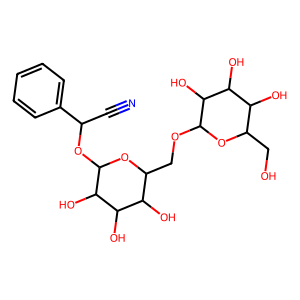

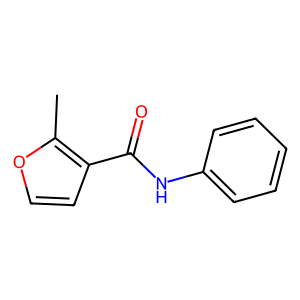

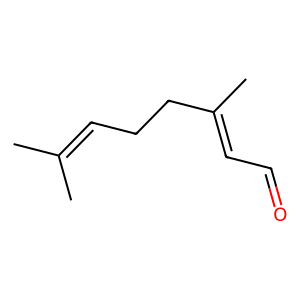

In [9]:
# 이미지 파일 출력하기
display_images(f_names)

- 타겟 변수 `logS` 분포 보기

In [10]:
dataset["measured log solubility in mols per litre"]

0      -0.770
1      -3.300
2      -2.060
3      -7.870
4      -1.330
        ...  
1123   -1.710
1124    0.106
1125   -3.091
1126   -3.180
1127   -4.522
Name: measured log solubility in mols per litre, Length: 1128, dtype: float64

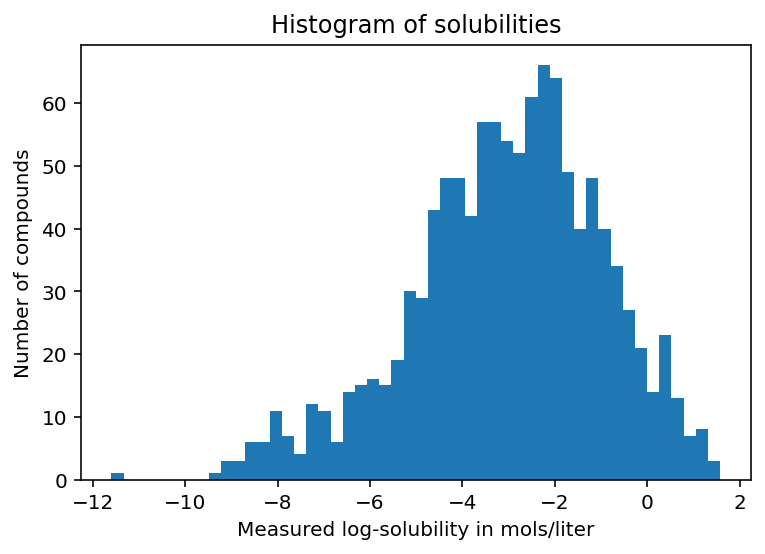

In [11]:
solubilities = np.array(dataset["measured log solubility in mols per litre"])
plt.hist(solubilities, 50)
plt.xlabel('Measured log-solubility in mols/liter')
plt.ylabel('Number of compounds')
plt.title('Histogram of solubilities')
plt.show()

## 특성화 (Featurization)

- 화합물 특성의 표현 방법을 선택 `featurization`(특성화)
- `SMILES`로부터 특성값을 생성하는 방법으로 `ECFP`를 사용
- CSVLoader 클래스 사용
 - 목적 변수는 task로, 입력변수는 feature_field로 지정한다
 - 특성은 의 featurizerf로 지정
 - `dc.feat` 모듈의 `CircularFingerprint` 클래스 사용


In [12]:
loader = dc.data.CSVLoader(
      tasks=["measured log solubility in mols per litre"], feature_field="smiles",
      featurizer=dc.feat.CircularFingerprint(size=1024))

# DiskDataset
- create_dataset()으로 DiskDataset을 만든다
- DiskDataset은 X, y, w, task, ids 등을 포함하는 데이터셋으로 편리하게 데이터를 다루는 포맷임
- 위에서 만든 loader를 사용하겠다

In [13]:
data_FP = loader.create_dataset("delaney-processed.csv")

In [14]:
type(loader)

deepchem.data.data_loader.CSVLoader

In [15]:
data_FP

<DiskDataset X.shape: (1128, 1024), y.shape: (1128, 1), w.shape: (1128, 1), task_names: ['measured log solubility in mols per litre']>

In [16]:
data_FP.X[0,:50]

array([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [17]:
data_FP.y[:5]

array([[-0.77],
       [-3.3 ],
       [-2.06],
       [-7.87],
       [-1.33]])

In [18]:
data_FP.w[:5]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [19]:
data_FP.ids[:5]

array(['OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ',
       'Cc1occc1C(=O)Nc2ccccc2', 'CC(C)=CCCC(C)=CC(=O)',
       'c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43', 'c1ccsc1'], dtype=object)

## 데이터 분할
- dc.splits에서 다양한 분할 방법을 제공
 - 아래에서는 ScaffoldSplitter를 사용

In [20]:
splitter = dc.splits.ScaffoldSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(data_FP)

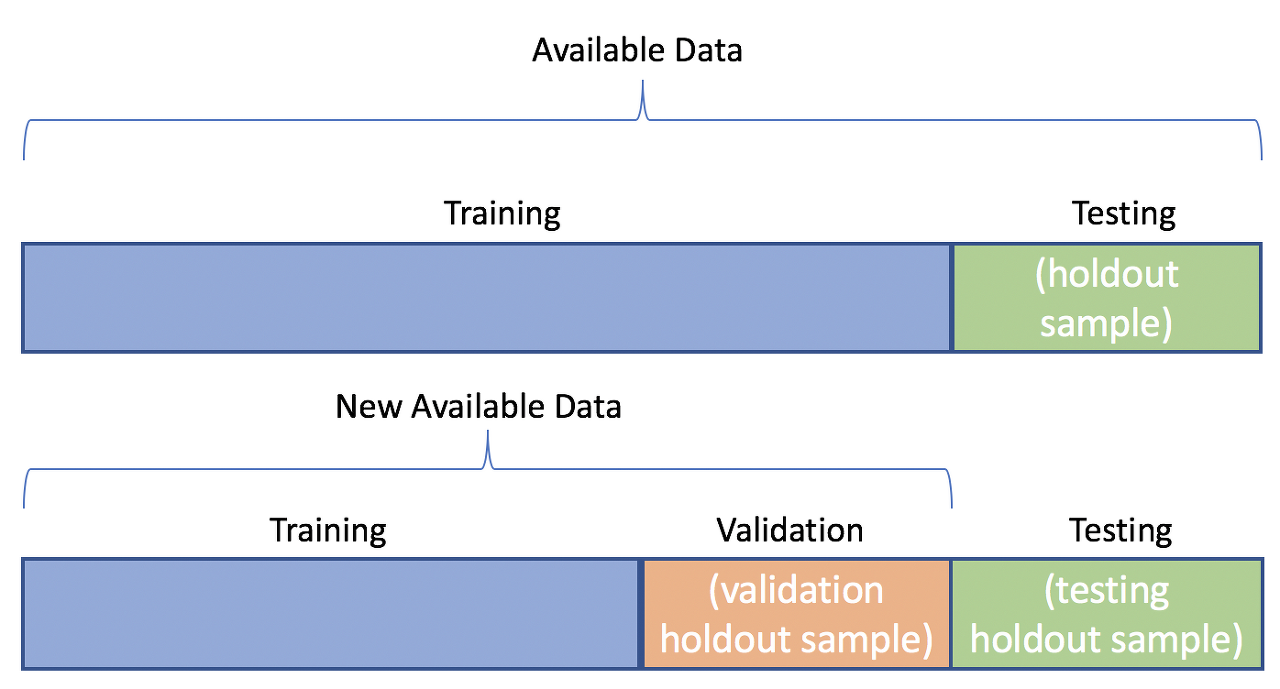

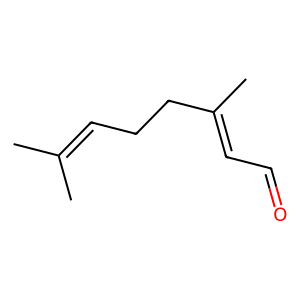

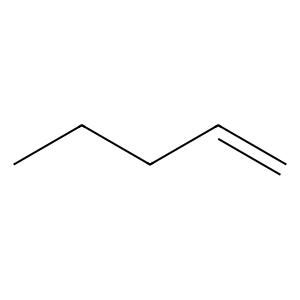

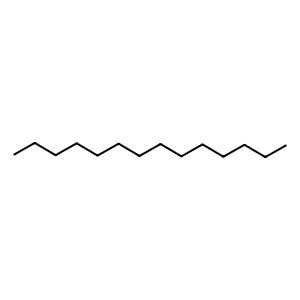

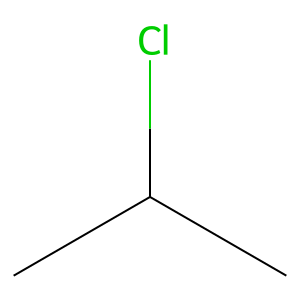

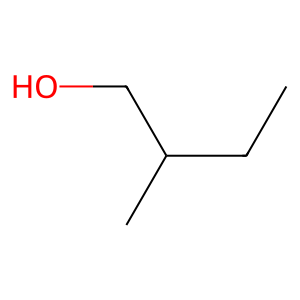

In [21]:
# 시각화 함수를 사용하여 일부 Train 데이터 시각화
train_mols = [Chem.MolFromSmiles(compound)
              for compound in train_dataset.ids]
display_images(mols_to_pngs(train_mols[:5], basename="train"))

# 스케일링
- 훈련데이터를 기준으로 스케일러를 만들고, 이후 검증 및 테스트 데이터도 같은 스케일러를 적용한다
- (주의) 검증 데이터에 대해서 스케일러를 다시 만들면 안된다 
 - 즉, 평균, 표준편차, 최소치, 최대치 등을 `검증 또는 테스트 데이터`에 대해서 새로 구하면 안된다

In [22]:
# 표준 스케일링 수행
transformers = [
dc.trans.NormalizationTransformer(transform_y=True, dataset=train_dataset)]

for dataset in [train_dataset, valid_dataset, test_dataset]:
  for transformer in transformers:
      dataset = transformer.transform(dataset)

In [23]:
train_dataset

<DiskDataset X.shape: (902, 1024), y.shape: (902, 1), w.shape: (902, 1), ids: ['CC(C)=CCCC(C)=CC(=O)' 'CCCC=C' 'CCCCCCCCCCCCCC' ...
 'Nc2cccc3nc1ccccc1cc23 ' 'C1CCCCCC1' 'OC1CCCCCC1'], task_names: ['measured log solubility in mols per litre']>

In [24]:
valid_dataset

<DiskDataset X.shape: (113, 1024), y.shape: (113, 1), w.shape: (113, 1), ids: ['Nc1ncnc2nc[nH]c12 ' 'Nc1nc(O)nc2nc[nH]c12 '
 'Fc1cccc(F)c1C(=O)NC(=O)Nc2cc(Cl)c(F)c(Cl)c2F ' ...
 'OC(Cn1cncn1)(Cn2cncn2)c3ccc(F)cc3F '
 'FC(F)(F)c1cccc(c1)N2CC(CCl)C(Cl)C2=O' 'CC1(C)CON(Cc2ccccc2Cl)C1=O'], task_names: ['measured log solubility in mols per litre']>

In [25]:
test_dataset

<DiskDataset X.shape: (113, 1024), y.shape: (113, 1), w.shape: (113, 1), ids: ['c1cc2ccc3cccc4ccc(c1)c2c34' 'Cc1cc(=O)[nH]c(=S)[nH]1'
 'Oc1ccc(cc1)C2(OC(=O)c3ccccc23)c4ccc(O)cc4 ' ...
 'c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43' 'Cc1occc1C(=O)Nc2ccccc2'
 'OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O '], task_names: ['measured log solubility in mols per litre']>

# 랜덤포레스트 모델
-`deepChem`은 `SklearnModel`을 통해서 `scikit-learn` 의 모델들을 사용할 수 있게 한다

In [26]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()

# sklearn 모델을 deepchem models로 변경
model = dc.models.SklearnModel(rfr)

#train_dataset에 포함된 X, w, y값을 사용하여 모델 훈련
model.fit(train_dataset)

## 모델 학습과 성능 평가
- `deepchem`의 `Evaluator` 객체의 `compute_model_performance()`로 평가

In [27]:
from deepchem.utils.evaluate import Evaluator
metric1 = dc.metrics.Metric(dc.metrics.r2_score)
metric2 = dc.metrics.Metric(dc.metrics.rms_score)

evaluator = Evaluator(model, valid_dataset, transformers)
scores = evaluator.compute_model_performance([metric1, metric2])
print(scores)

{'r2_score': 0.15855789882202354, 'rms_score': 3.7477037874058867}


## 모델 최적화
- 하이퍼 파라미터 튜닝 수행
- model_dir은 dc.models.SklearnModel 함수의 인자로 다른 디렉토리에 생성한 모델이 있는 경우에 불러오기 위한 인자임

In [28]:
def rf_model_builder(n_estimators, max_features, max_depth, model_dir):
  rfr = RandomForestRegressor(
      n_estimators=n_estimators, max_features=max_features, max_depth=max_depth)
  return dc.models.SklearnModel(rfr, model_dir)

#하이퍼파라미터의 여러개의 값 설정 
params_dict = {
    "n_estimators": [50, 100],
    "max_features": [0.2, 0.25, 0.5], # 1024개의 컬럼이 있다 (FP) 102개, 
    "max_depth" : [17, 19, 21]
}

metric = dc.metrics.Metric(dc.metrics.r2_score)
optimizer = dc.hyper.GridHyperparamOpt(rf_model_builder)

# 최고 성능의 모델, 최고 성능의 하이퍼파라미터, 모든 결과를 리턴한다
best_rf, best_rf_hyperparams, all_rf_results = optimizer.hyperparam_search(params_dict, train_dataset, valid_dataset, metric, transformers)

In [29]:
#최고 성능을 보이는 모델 하이퍼파라미터 출력
print(best_rf_hyperparams)
#모든 탐색 성능 평가 결과 출력
print(all_rf_results)

{'n_estimators': 100, 'max_features': 0.2, 'max_depth': 21}
{'_max_depth_17_max_features_0.200000_n_estimators_50': 0.22148927242284266, '_max_depth_19_max_features_0.200000_n_estimators_50': 0.22755399275874633, '_max_depth_21_max_features_0.200000_n_estimators_50': 0.18988331947780446, '_max_depth_17_max_features_0.250000_n_estimators_50': 0.2334529422175493, '_max_depth_19_max_features_0.250000_n_estimators_50': 0.1944658631328432, '_max_depth_21_max_features_0.250000_n_estimators_50': 0.20115280932651636, '_max_depth_17_max_features_0.500000_n_estimators_50': 0.19976055209692, '_max_depth_19_max_features_0.500000_n_estimators_50': 0.17445204739307163, '_max_depth_21_max_features_0.500000_n_estimators_50': 0.20335206272513096, '_max_depth_17_max_features_0.200000_n_estimators_100': 0.23851653955979346, '_max_depth_19_max_features_0.200000_n_estimators_100': 0.21375681648039613, '_max_depth_21_max_features_0.200000_n_estimators_100': 0.2451374401046379, '_max_depth_17_max_features_0.

In [30]:
# 최대 value 찾기
max(all_rf_results.values())

0.2451374401046379

In [31]:
# 딕셔너리에서 최대 value를 갖는 키 찾기
max(all_rf_results, key=all_rf_results.get)

'_max_depth_21_max_features_0.200000_n_estimators_100'

# 그래프 컨볼루션 모델 사용하기
- 앞에서는 랜덤 포레스트 모델을 사용했고, 특성으로 ECFP를 사용했다.
- 그래프 컨볼류션을 사용하려면 특성을 그래프로 표현해야 한다 (ConvMol 구조 사용)
 - 자세한 내용을 뒤에서 다시 다룸

![Molecular Graph](https://github.com/deepchem/deepchem/blob/master/examples/tutorials/assets/basic_graphs.gif?raw=1)

## 데이터
- load_delaney() 함수를 사용하여 데이터를 다운로드하면서 featurizer 옵션을 선택


In [32]:
tasks, datasets, transformers = dc.molnet.load_delaney(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = datasets

In [33]:
train_dataset.X[0]

## 모델 구성
- graph convolutional network 타입의 모델을 생성(construct)하며 구체적으로 GraphConvModel 클래스를 사용함
- 이 프로그램에서 사용할 객체 이름을 model이라고 지정함
 - 객체에서는 클래스에서 미리 정의된 함수와 파라미터들을 사용할 수 있게 된다
- 회귀분석이며 작업(목적 변수 y) 수는 하나임을 표현
- 데이터를 랜덤하게 20% 사용하지 않도록 지정 (더 다양한 데이터를 사용한 효과를 얻어 성능을 개선시킴)
 - dropout=0.2


# 학습
- 학습시키는 함수는 보통 fit()을 사용한다
 - fit에는 여러가지 변형된 함수가 있다
- 학습에는 훈련 데이터를 사용한다
- 훈련 데이터를 몇 번 반복하여 사용할지를 지정한다 (epoch)


In [34]:
model = dc.models.GraphConvModel(n_tasks=1, mode='regression', dropout=0.2)
model.fit(train_dataset, nb_epoch=100)

2022-11-05 14:39:10.501415: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_14:0", shape=(343,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_13:0", shape=(343, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/tensorflow/python

0.10522307395935059

# 모델 평가

- 훈련된 모델의 성능을 평가한다.
 - evaluate() 함수를 사용하겠다
 - 측정할 성능평가 지표(metrics)로 Pearson correlation, r<sup>2</sup>를 사용하겠다고 지정
- 훈련 데이터에 대한 성능과, 검증 데이터에 대한 성능을 모두 출력해본다 (과대적합인지를 파악하기 위함)

In [35]:
metric1 = dc.metrics.Metric(dc.metrics.mae_score)
metric2 = dc.metrics.Metric(dc.metrics.r2_score)
print("Training set score:", model.evaluate(train_dataset, [metric1, metric2], transformers))
print("Test set score:", model.evaluate(test_dataset, [metric1, metric2], transformers))

Training set score: {'mae_score': 0.5645665798847656, 'r2_score': 0.8833001092255709}
Test set score: {'mae_score': 1.0620355044656564, 'r2_score': 0.6269908907458572}


- R2 점수로 0.55를 얻었다

## 샘플 테스트 데이터에 대한 예측

In [36]:
solubilities = model.predict_on_batch(test_dataset.X)
for molecule, solubility, test_solubility in zip(test_dataset.ids, solubilities, test_dataset.y):
    print(solubility, test_solubility, molecule)

[-1.4921072] [-1.60114461] c1cc2ccc3cccc4ccc(c1)c2c34
[0.67995936] [0.20848251] Cc1cc(=O)[nH]c(=S)[nH]1
[-0.9047974] [-0.01602738] Oc1ccc(cc1)C2(OC(=O)c3ccccc23)c4ccc(O)cc4 
[-2.0134306] [-2.82191713] c1ccc2c(c1)cc3ccc4cccc5ccc2c3c45
[-1.4926066] [-0.52891635] C1=Cc2cccc3cccc1c23
[2.1232398] [1.10168349] CC1CO1
[-0.5067595] [-0.88987406] CCN2c1ccccc1N(C)C(=S)c3cccnc23 
[-1.3283513] [-0.52649706] CC12CCC3C(CCc4cc(O)ccc34)C2CCC1=O
[-1.4848754] [-0.76358725] Cn2cc(c1ccccc1)c(=O)c(c2)c3cccc(c3)C(F)(F)F
[0.13058504] [-0.64020358] ClC(Cl)(Cl)C(NC=O)N1C=CN(C=C1)C(NC=O)C(Cl)(Cl)Cl 
[-0.25261328] [-0.38569452] COc2c1occc1cc3ccc(=O)oc23 
[0.29885316] [-0.62568785] CN2C(=C(O)c1ccccc1S2(=O)=O)C(=O)Nc3ccccn3 
[0.5350718] [-0.39585553] Cc3cc2nc1c(=O)[nH]c(=O)nc1n(CC(O)C(O)C(O)CO)c2cc3C
[-1.1499354] [-2.05306753] c1ccc(cc1)c2ccc(cc2)c3ccccc3
[-0.56966424] [-0.29666474] CC34CC(=O)C1C(CCC2=CC(=O)CCC12C)C3CCC4(=O) 
[-0.64297944] [-0.73213651] c1ccc2c(c1)sc3ccccc23
[-1.2507502] [-1.27744393] CC23Cc1cnoc1

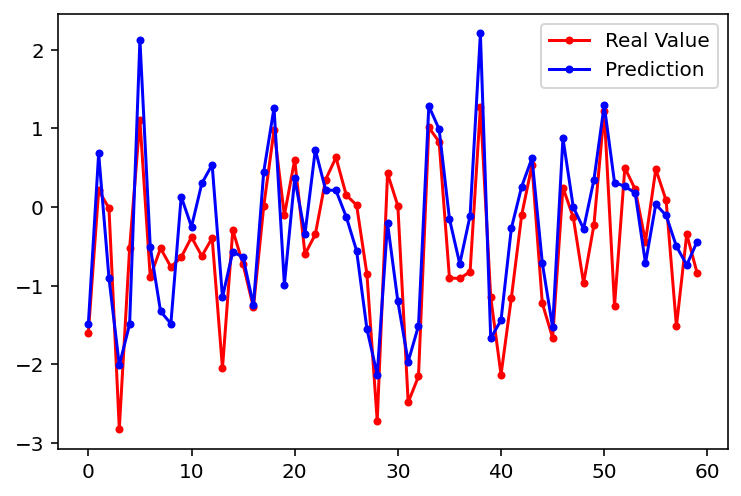

In [37]:
# 60개의 테스트 샘플만 비교했다
plt.plot(test_dataset.y[:60], "r.-", label='Real Value')
plt.plot(solubilities[:60], "b.-",  label='Prediction')
plt.legend()

## 임의의 샘플에 적용해보기

In [39]:
# from rdkit import Chem

smiles = ['COC(C)(C)CCCC(C)CC=CC(C)=CC(=O)OC(C)C',
          'CCOC(=O)CC',
          'CSc1nc(NC(C)C)nc(NC(C)C)n1',
          'CC(C#C)N(C)C(=O)Nc1ccc(Cl)cc1',
          'Cc1cc2ccccc2cc1C']
mols = [Chem.MolFromSmiles(s) for s in smiles]
featurizer = dc.feat.ConvMolFeaturizer()
x = featurizer.featurize(mols)
predicted_solubility = model.predict_on_batch(x)
for m,s in zip(smiles, predicted_solubility):
    print()
    print('Molecule:', m)
    print('Predicted solubility:', s)


Molecule: COC(C)(C)CCCC(C)CC=CC(C)=CC(=O)OC(C)C
Predicted solubility: [-0.9656617]

Molecule: CCOC(=O)CC
Predicted solubility: [1.4959676]

Molecule: CSc1nc(NC(C)C)nc(NC(C)C)n1
Predicted solubility: [-0.20473579]

Molecule: CC(C#C)N(C)C(=O)Nc1ccc(Cl)cc1
Predicted solubility: [-0.19678381]

Molecule: Cc1cc2ccccc2cc1C
Predicted solubility: [-0.97827905]


## ConvMol  소개

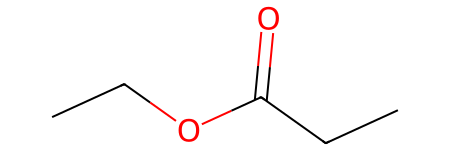

In [40]:
# 위의 샘플에서 두번째 분자 보기
Chem.MolFromSmiles("CCOC(=O)CC")

In [43]:
x

array([<deepchem.feat.mol_graphs.ConvMol object at 0x14a710730>,
      dtype=object)

In [41]:
# ConvMol 특성의 구조 (원자가 7이고, 특성 벡터수가 75임)
x[1].atom_features.shape

(7, 75)

In [42]:
x[1].get_atom_features()

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0.

In [44]:
# 7개 원자의 인접 노드 번호들 보기
x[1].get_adjacency_list()

[[3], [6], [5], [0, 4], [3, 6], [6, 2], [4, 1, 5]]

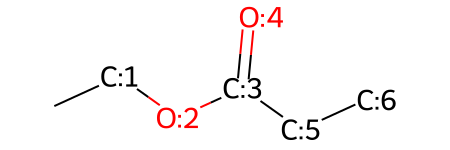

In [48]:
mol=Chem.MolFromSmiles("CCOC(=O)CC")
for atom in mol.GetAtoms():
    atom.SetAtomMapNum(atom.GetIdx())
mol

In [45]:
print(x[1].get_deg_adjacency_lists())

[array([], shape=(0, 0), dtype=int32), array([[3],
       [6],
       [5]], dtype=int32), array([[0, 4],
       [3, 6],
       [6, 2]], dtype=int32), array([[4, 1, 5]], dtype=int32), array([], shape=(0, 4), dtype=int32), array([], shape=(0, 5), dtype=int32), array([], shape=(0, 6), dtype=int32), array([], shape=(0, 7), dtype=int32), array([], shape=(0, 8), dtype=int32), array([], shape=(0, 9), dtype=int32), array([], shape=(0, 10), dtype=int32)]


In [46]:
for i in range(4):
  print(x[1].get_deg_adjacency_lists()[i])

[]
[[3]
 [6]
 [5]]
[[0 4]
 [3 6]
 [6 2]]
[[4 1 5]]


In [47]:
x[1].get_deg_slice()

array([[0, 0],
       [0, 3],
       [3, 3],
       [6, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0]], dtype=int32)